In [1]:
import numpy as np
import pandas as pd


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# Synthetic dataset

In [31]:
np.random.seed(42)
n_samples = 10000

# === Numeric Features ===
feature_num1 = np.random.normal(loc=50, scale=10, size=n_samples)
feature_num2 = np.random.uniform(low=0, high=100, size=n_samples)

# === Categorical Features ===
cat1_choices = ['A', 'B', 'C']
cat2_choices = ['X', 'Y']
cat3_choices = ['Red', 'Green', 'Blue', 'Yellow']

feature_cat1 = np.random.choice(cat1_choices, size=n_samples).astype(object)
feature_cat2 = np.random.choice(cat2_choices, size=n_samples).astype(object)
feature_cat3 = np.random.choice(cat3_choices, size=n_samples).astype(object)

# === Target Variable ===
# Target is a noisy function of inputs + category encodings
target = (
    0.4 * np.nan_to_num(feature_num1)
    + 0.25 * feature_num2
    + np.where(feature_cat1 == 'A', 10, 0)
    + np.where(feature_cat2 == 'X', -5, 5)
    + np.random.normal(0, 5, size=n_samples)
)

# Inject outliers
outlier_indices = np.random.choice(n_samples, size=5, replace=False)
feature_num1[outlier_indices[:3]] = feature_num1[outlier_indices[:3]] + 80  # big positive outliers
feature_num2[outlier_indices[3:]] = feature_num2[outlier_indices[3:]] - 120  # big negative outliers

# Inject missing values
missing_indices = np.random.choice(n_samples, size=10, replace=False)
feature_num1[missing_indices[:5]] = np.nan
feature_cat2[missing_indices[5:]] = np.nan

# Combine into DataFrame
df = pd.DataFrame({
    'feature_num1': feature_num1,
    'feature_num2': feature_num2,
    'feature_cat1': feature_cat1,
    'feature_cat2': feature_cat2,
    'feature_cat3': feature_cat3,
    'target': target
})

# Display a sample
df.head(10)


,feature_num1,feature_num2,feature_cat1,feature_cat2,feature_cat3,target
0,54.967142,32.125517,C,Y,Green,41.243231
1,48.617357,10.301919,A,Y,Blue,43.383554
2,56.476885,7.180755,C,Y,Blue,32.790054
3,65.230299,9.427598,C,Y,Blue,32.322380
4,47.658466,58.286936,B,Y,Yellow,47.641281
5,47.658630,5.166218,C,X,Red,20.296309
6,65.792128,33.692687,A,X,Red,39.154831
7,57.674347,75.319970,B,X,Green,27.127514
8,45.305256,29.434817,C,X,Green,24.787135
9,55.425600,76.330808,B,X,Red,42.460479


# EDA
- Explore missing values
- Identify and visualize outliers

- Visualize predictive relationships:
    - Correlation matrix
    - Scatter plots (numeric vs. target)
    - Box plots (categorical vs. target)

### Missing values

In [32]:
missing_summary = df.isnull().sum()
missing_summary

feature_num1    5
feature_num2    0
feature_cat1    0
feature_cat2    5
feature_cat3    0
target          0
dtype: int64

In [33]:
df.feature_cat2.value_counts(dropna=False)

feature_cat2
Y      5100
X      4895
NaN       5
Name: count, dtype: int64

### check distributions of numeric features

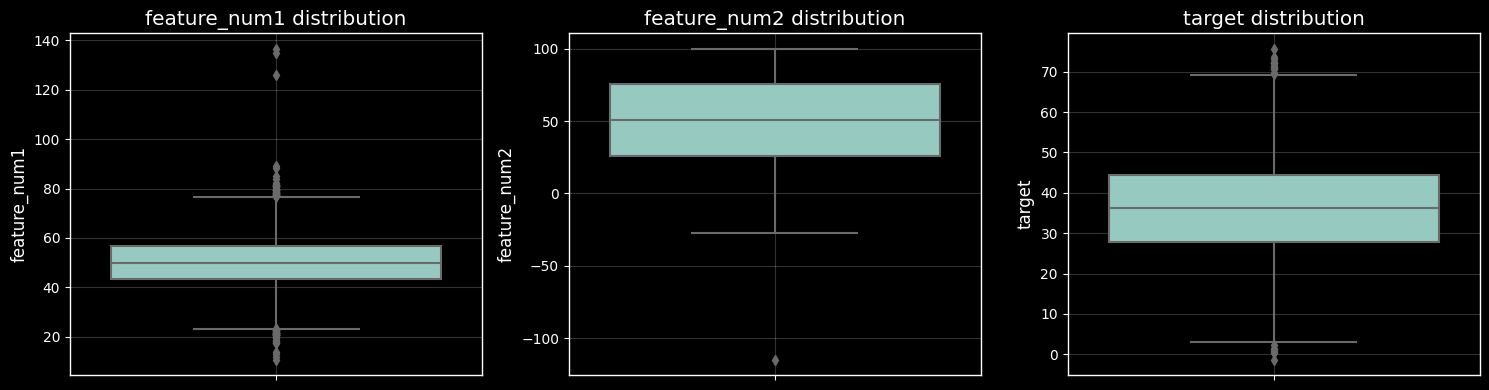

In [34]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(5 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'{col} distribution')
    ax.set_ylabel(col); ax.grid(alpha=0.2)

plt.tight_layout()

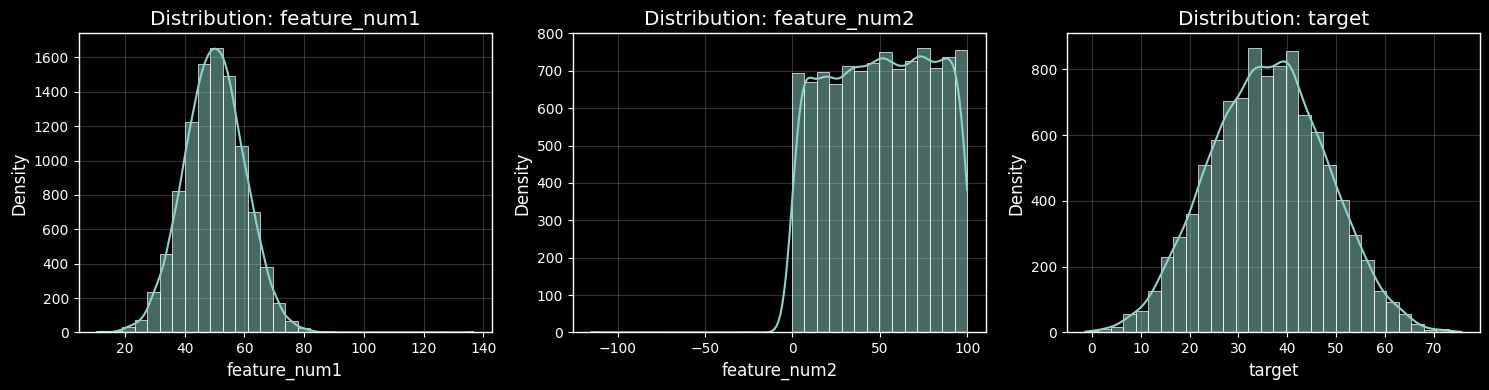

In [35]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(5 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.histplot(df[col], kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution: {col}')
    ax.set_ylabel('Density'); ax.grid(alpha=0.2)

plt.tight_layout()

### Check outliers of numeric features
- can either remove or winsorize depending on application

In [36]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Compute z-scores manually
z_scores = np.abs((df[numeric_features] - df[numeric_features].mean()) / df[numeric_features].std())

# Count outliers (Z > 3)
outliers = (z_scores > 3).sum()
print("Outliers (Z > 3):")
print(outliers)

Outliers (Z > 3):
feature_num1    29
feature_num2     1
target           9
dtype: int64


### Check correlation matrix

In [37]:
# Correlation matrix for numeric variables
numeric_features = ['feature_num1', 'feature_num2', 'target']
corr = df[numeric_features].corr()
corr

,feature_num1,feature_num2,target
feature_num1,1.000000,-0.002677,0.328805
feature_num2,-0.002677,1.000000,0.610222
target,0.328805,0.610222,1.000000


> if you want to include categoricals you have to one hot encode them (oridnal would confuse output)

In [38]:
# Define categorical and numeric columns
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']
numeric_features = ['feature_num1', 'feature_num2', 'target']

# One-hot encode the categoricals
df_onehot = pd.get_dummies(df[categorical_features], drop_first=False)

# Combine with numeric features
df_encoded = pd.concat([df[numeric_features], df_onehot], axis=1)

# Compute correlation matrix
corr_matrix = df_encoded.corr()
# only need to see the ones correlated with the target (its a big matrix otherwise)
corr_matrix['target']

feature_num1           0.328805
feature_num2           0.610222
target                 1.000000
feature_cat1_A         0.383294
feature_cat1_B        -0.183896
feature_cat1_C        -0.199054
feature_cat2_X        -0.433344
feature_cat2_Y         0.432872
feature_cat3_Blue     -0.009187
feature_cat3_Green    -0.010051
feature_cat3_Red       0.009121
feature_cat3_Yellow    0.010083
Name: target, dtype: float64

### Check predictive power of the features

> numeric - scatter plots

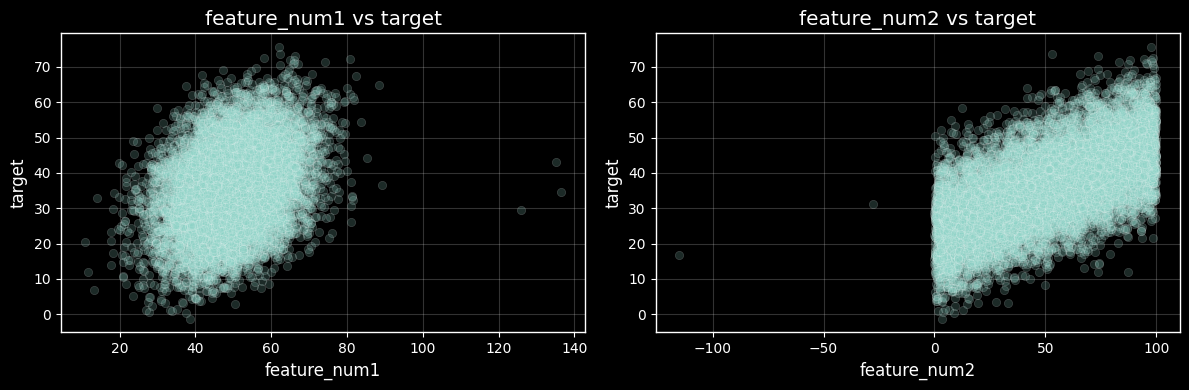

In [39]:
numeric_features = ['feature_num1', 'feature_num2']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(6 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(data=df, x=col, y=target_col, ax=ax, alpha=0.2)
    ax.set_title(f'{col} vs {target_col}')
    ax.set_xlabel(col); ax.set_ylabel(target_col); ax.grid(alpha=0.2)

plt.tight_layout()

> categoricals

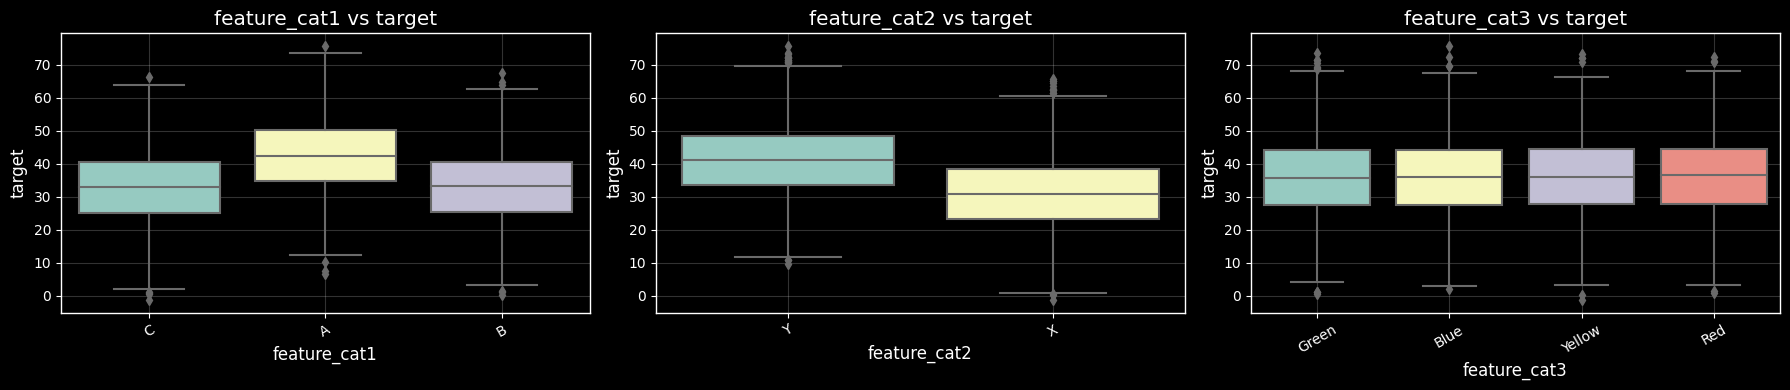

In [40]:
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(6 * len(categorical_features), 4))

for ax, col in zip(axes, categorical_features):
    sns.boxplot(data=df, x=col, y=target_col, ax=ax)
    ax.set_title(f'{col} vs {target_col}')
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(alpha=0.2)

plt.tight_layout()

# Prepare for Training

## Train test split

In [41]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=None):
    """
    Splits X and y into train/val/test with given proportions.

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Proportions must sum to 1."

    # First split: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1.0 - train_size), random_state=random_state
    )

    # Second split: val vs test (on temp set)
    val_ratio = val_size / (val_size + test_size)  # relative size within the remaining 20%
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1.0 - val_ratio), random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [42]:
# Split features and target
X = df.drop(columns='target')
y = df['target']

# Call the split function
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, random_state=42)

# Check sizes
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

Train: 8000 samples
Validation: 1000 samples
Test: 1000 samples


## Impute using means and mode 
could also just drop 

In [43]:
# Separate feature types
numeric_features = ['feature_num1', 'feature_num2']
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']

# === Compute imputation values from training set ===

# For numeric: use mean
numeric_means = X_train[numeric_features].mean()

# Apply numeric mean imputation
X_train[numeric_features] = X_train[numeric_features].fillna(numeric_means)
X_val[numeric_features] = X_val[numeric_features].fillna(numeric_means)
X_test[numeric_features] = X_test[numeric_features].fillna(numeric_means)


# For categorical: use most frequent value
categorical_modes = X_train[categorical_features].mode().iloc[0]

# Apply categorical mode imputation
X_train[categorical_features] = X_train[categorical_features].fillna(categorical_modes)
X_val[categorical_features] = X_val[categorical_features].fillna(categorical_modes)
X_test[categorical_features] = X_test[categorical_features].fillna(categorical_modes)

# verify no nulls
display('train',X_train.isnull().sum())
display('valid',X_val.isnull().sum())
display('test',X_test.isnull().sum())

'train'

feature_num1    0
feature_num2    0
feature_cat1    0
feature_cat2    0
feature_cat3    0
dtype: int64

'valid'

feature_num1    0
feature_num2    0
feature_cat1    0
feature_cat2    0
feature_cat3    0
dtype: int64

'test'

feature_num1    0
feature_num2    0
feature_cat1    0
feature_cat2    0
feature_cat3    0
dtype: int64

## Encode categoricals
Unnecessary for xgboost

In [44]:
from sklearn.preprocessing import OrdinalEncoder

# Define categorical and numerical columns
categorical_cols = ['feature_cat1', 'feature_cat2', 'feature_cat3']
numerical_cols = ['feature_num1', 'feature_num2']

# Fit encoder on training data only
encoder = OrdinalEncoder()
X_train_cat = encoder.fit_transform(X_train[categorical_cols])

# Apply to val/test using the same encoder
X_val_cat = encoder.transform(X_val[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Combine with numeric features
X_train_all = np.hstack([X_train_cat, X_train[numerical_cols].values])
X_val_all = np.hstack([X_val_cat, X_val[numerical_cols].values])
X_test_all = np.hstack([X_test_cat, X_test[numerical_cols].values])

> for xgboost all we need to do is assign them as cat cols

In [45]:
# Assume your categorical features are named
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']

# Cast to categorical in all splits
for col in categorical_features:
    categories = X_train[col].astype('category').cat.categories

    X_train[col] = pd.Categorical(X_train[col], categories=categories)
    X_val[col]   = pd.Categorical(X_val[col], categories=categories)
    X_test[col]  = pd.Categorical(X_test[col], categories=categories)

## Set up dMatrices

In [46]:
import xgboost as xgb

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Tune and Train

### Tune with optuna

In [48]:
import optuna
# set the verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    param = {
        "booster": "gbtree",
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-4, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
    }

    model = xgb.train(
        param,
        dtrain,
        num_boost_round=100,
        evals=[(dval, "validation")],
        early_stopping_rounds=25,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(np.mean((preds - y_val) ** 2))
    return rmse

# Run study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

Best trial:
FrozenTrial(number=33, state=TrialState.COMPLETE, values=[4.9372850629055485], datetime_start=datetime.datetime(2025, 7, 10, 16, 35, 41, 936710), datetime_complete=datetime.datetime(2025, 7, 10, 16, 35, 42, 695176), params={'max_depth': 3, 'learning_rate': 0.13937538945383432, 'subsample': 0.915363993372225, 'colsample_bytree': 0.9696237024974791, 'lambda': 3.649925321821256, 'alpha': 8.202461047210496, 'min_child_weight': 5.159066071196927}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'lambda': FloatDistribution(high=10.0, log=True, low=0.0001, step=None), 'alpha': FloatDistribution(high=10.0, log=True, low=0.0001, step=None), 'min_child_weight': FloatDistr

In [58]:
pd.concat([y_val,y_train])

5050    23.588314
4775    17.180094
461     20.925674
3194    36.413644
7420    23.653668
          ...    
5734    57.290452
5191    26.814399
5390    35.362355
860     35.987421
7270    20.453338
Name: target, Length: 9000, dtype: float64

### Retrain final model

In [59]:
# Combine training and validation sets
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Create final training DMatrix
dtrainval = xgb.DMatrix(X_trainval, label=y_trainval, enable_categorical=True)

# Use test DMatrix from earlier
# dtest = xgb.DMatrix(X_test_all, label=y_test)

# Extract best params and add fixed entries
best_params = study.best_trial.params

# Add required objective, metric, and any other fixed values
best_params.update({
    "booster": "gbtree",
    "objective": "reg:squarederror",  # change to "binary:logistic" for classification
    "eval_metric": "rmse"
})

# Retrain model
final_model = xgb.train(
    best_params,
    dtrainval,
    num_boost_round=study.best_trial.number + 50  # or manually pick a larger value
)

# Optional: predict on test set
preds_test = final_model.predict(dtest)

# Evaluate
rmse_test = np.sqrt(np.mean((preds_test - y_test) ** 2))
print(f"Test RMSE: {rmse_test:.4f}")

Test RMSE: 5.1274


# Feature importances
- 'gain': average improvement in loss when the feature is used in a split (most informative).

- 'weight': number of times a feature is used in splits (can overvalue repeated but weak features).

- 'cover': average coverage (number of samples affected) per split involving the feature.

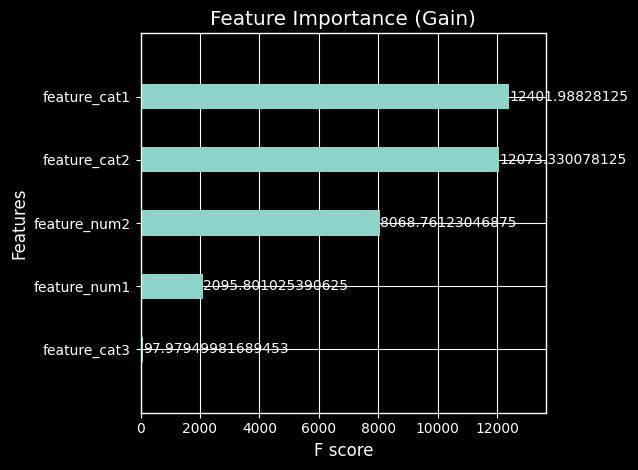

In [60]:
# Assign feature names to the booster (for plotting)
final_model.feature_names = list(X_train.columns)

# Plot importance (by gain, cover, or weight)
xgb.plot_importance(
    final_model,
    importance_type='gain',   # alternatives: 'weight', 'cover'
    max_num_features=10,      # adjust as needed
    height=0.4
)
plt.title("Feature Importance (Gain)")
plt.tight_layout()

# Shap

- each feature’s global impact on the prediction distribution.

- Color encodes the feature value (low = blue, high = red).

- Horizontal axis is the SHAP value: how much a feature contributes (positively or negatively) to the prediction.

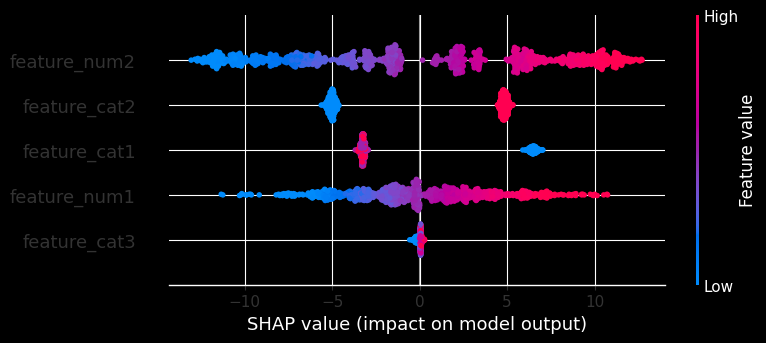

In [88]:
import shap

# Load JS visualization support
shap.initjs()

# Use TreeExplainer for XGBoost model
explainer = shap.Explainer(final_model)

# Compute SHAP values on the test set
shap_values = explainer(dtest)

# Convert feature names for SHAP plots
shap_values.feature_names = dtest.feature_names

# Summary plot (global importance)
shap.plots.beeswarm(shap_values, max_display=10)

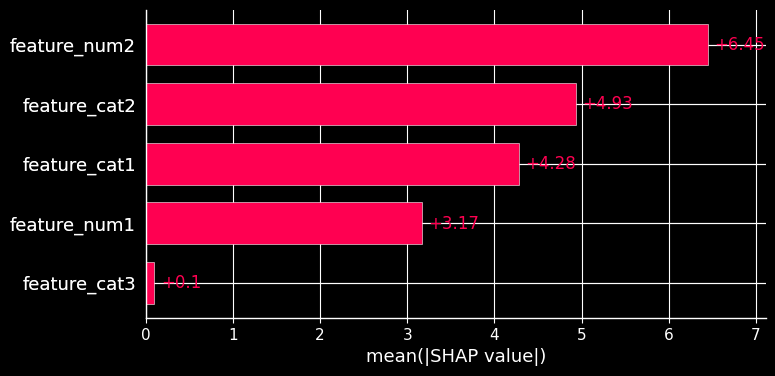

In [91]:
# Bar plot — global mean absolute SHAP value for each feature
shap.plots.bar(shap_values, max_display=10);

> shap pdp see https://docs.google.com/document/d/1YolTNjNTICJn7fNCx1-EB0Z2DoRVbRt-Wk4RDT8xceU/edit?tab=t.0#heading=h.ilo62hh4vx

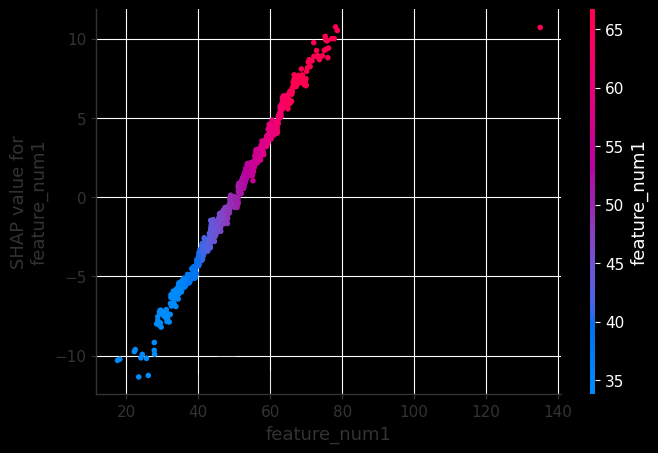

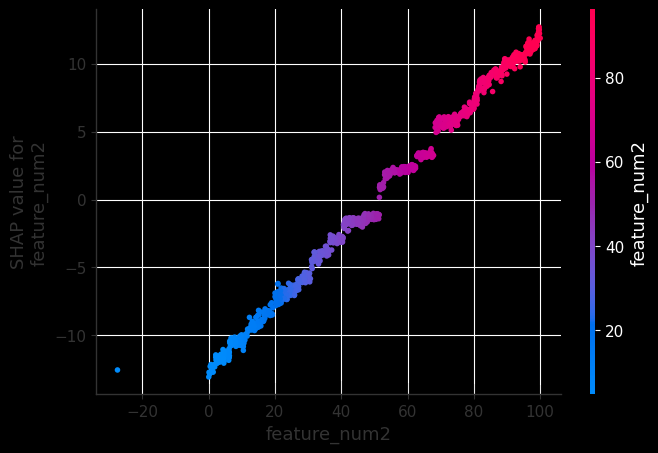

In [99]:
for col in numeric_features:
    shap.plots.scatter(shap_values[:, col], color=shap_values[:, col])

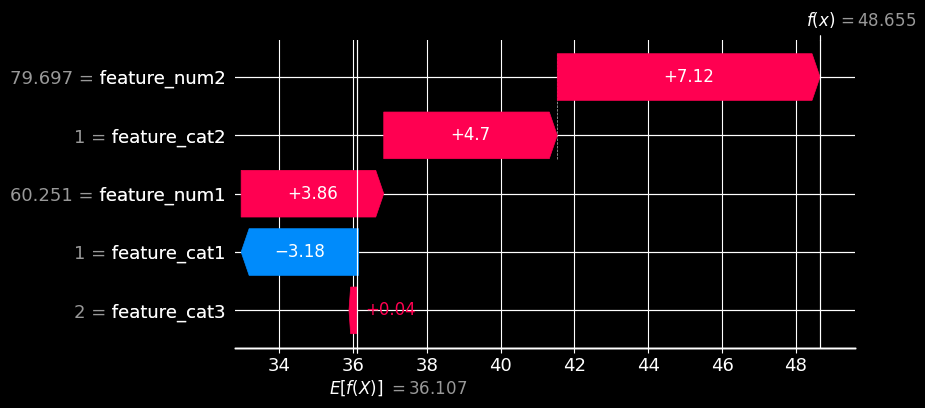

In [67]:
# Example: explanation for the first test instance
shap.plots.waterfall(shap_values[0])

In [68]:
for col in categorical_features:
    print(f"Category mapping for '{col}':")
    print(dict(enumerate(X_test[col].cat.categories)))
    print()

Category mapping for 'feature_cat1':
{0: 'A', 1: 'B', 2: 'C'}

Category mapping for 'feature_cat2':
{0: 'X', 1: 'Y'}

Category mapping for 'feature_cat3':
{0: 'Blue', 1: 'Green', 2: 'Red', 3: 'Yellow'}



# Partial dependence plots (sklearn)

PDPs work best for features with a monotonic or linear influence, though they can still be informative for non-linear ones.

For categorical variables, PDPs assume ordinal relationships (because we encoded them that way). For interpretability, be cautious if the encoding does not represent meaningful order.

See here for explanation : https://docs.google.com/document/d/1YolTNjNTICJn7fNCx1-EB0Z2DoRVbRt-Wk4RDT8xceU/edit?tab=t.0#heading=h.ilo62hh4vx

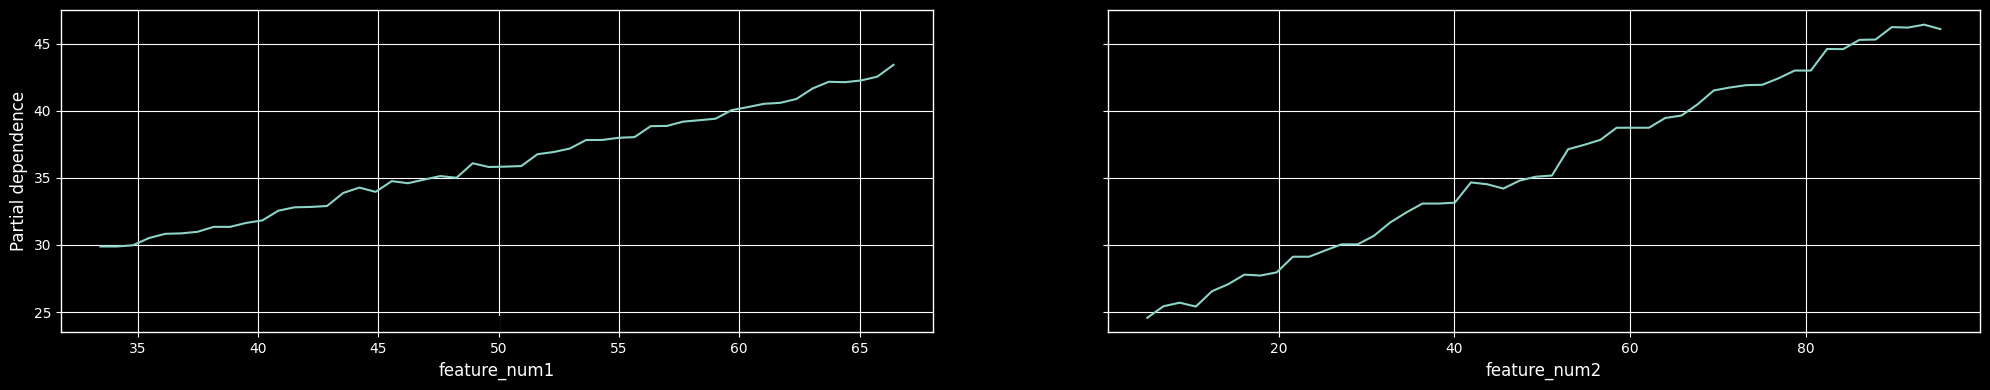

In [100]:
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay

# Wrap the model as an XGBRegressor from sklearn
xgb_model = XGBRegressor(
    **best_params,
    enable_categorical=True,
    tree_method='hist'  # required when using categorical features
)
xgb_model.fit(X_trainval, y_trainval)  # re-train for sklearn compatibility

# Plot PDPs for all features
fig, ax = plt.subplots(figsize=(20, 4))
PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_trainval,
    features=numeric_features,
    grid_resolution=50,
    ax=ax
)

plt.tight_layout()

> Categoricals

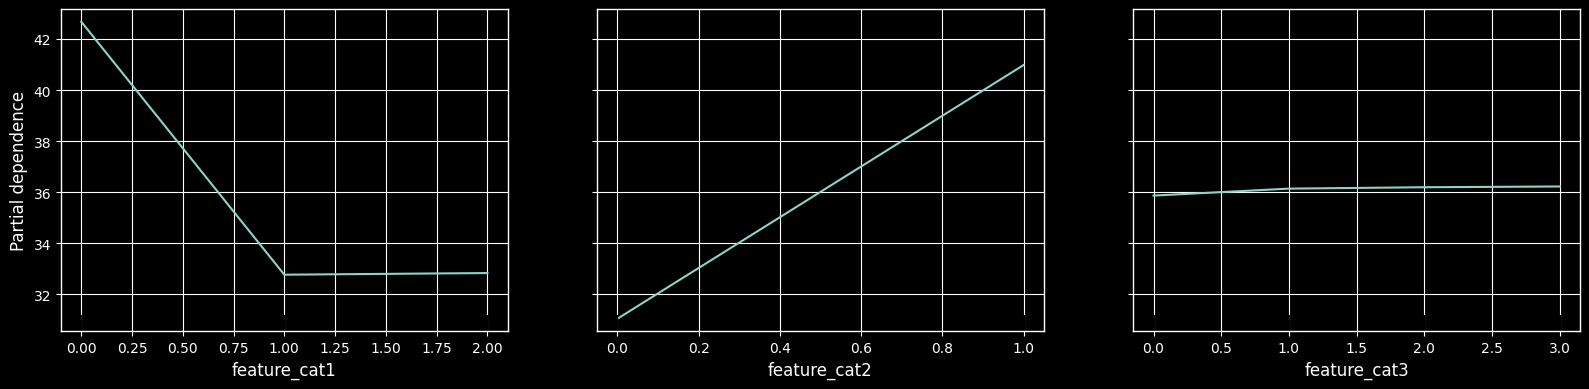

In [86]:
# Encode categorical features as codes
X_trainval_pdp = X_trainval.copy()
for col in categorical_features:
    X_trainval_pdp[col] = X_trainval_pdp[col].cat.codes

fig, ax = plt.subplots(figsize=(16, 4))

PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_trainval_pdp,
    features=categorical_features,  # or use index
    grid_resolution=10,
    ax=ax
)
plt.tight_layout()
plt.show()

> 2d

<Figure size 800x600 with 0 Axes>

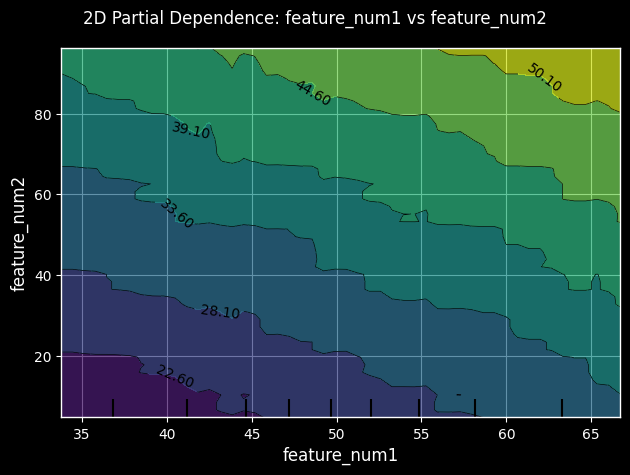

In [102]:
# Define the pair of features you want to analyze
features_2d = [('feature_num1', 'feature_num2')]

# Plot the 2D partial dependence
fig = plt.figure(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(
    xgb_model,            # your fitted XGBRegressor
    X_test,           # raw DataFrame used for fitting
    features=features_2d,
    grid_resolution=50,
    kind='average',       # default: marginal effect
)

plt.suptitle("2D Partial Dependence: feature_num1 vs feature_num2")
plt.tight_layout()
plt.show()

### Shap pdp